<a href="https://colab.research.google.com/github/priyanshu3489/Deepfake-detection-/blob/Deepfake-Audio-detection/Audio_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# Load the CSV file
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AVCeleb Dataset/Audio_dataset.csv')

# Display the first few rows of the dataset
print(data.head())


                                          Audio Path  Label
0  /content/drive/MyDrive/Colab Notebooks/AVCeleb...      0
1  /content/drive/MyDrive/Colab Notebooks/AVCeleb...      1
2  /content/drive/MyDrive/Colab Notebooks/AVCeleb...      1
3  /content/drive/MyDrive/Colab Notebooks/AVCeleb...      1
4  /content/drive/MyDrive/Colab Notebooks/AVCeleb...      1


# **Features extraction**

In [ ]:
# Function to extract features from an audio file
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)

    # Extracting Spectral Features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

    # Extracting MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Combining all features into a single array
    features = np.hstack([spectral_centroid, spectral_bandwidth, spectral_rolloff, mfccs_mean])
    return features

# Extract features and labels from the dataset
X = []
y = []

for index, row in data.iterrows():
    audio_path = row['Audio Path']
    label = row['Label']
    try:
        features = extract_features(audio_path)
        X.append(features)
        y.append(label)
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)


KeyboardInterrupt: 

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
print(X_train)

[[-1.65163211 -1.7059233  -1.72474989 ... -0.75279753 -0.4525362
   0.49507375]
 [ 0.44034824  0.87592452  0.1753081  ...  0.52524348 -1.04825447
   1.10439904]
 [-0.53843954 -0.79202441 -0.56197439 ...  1.66955355  0.79039961
   0.00736254]
 ...
 [-0.91508818 -1.07753709 -0.95244897 ...  0.88173803 -0.55235558
  -0.90089081]
 [-0.84936162 -1.1730983  -0.86075213 ...  1.17890604  0.29802446
  -0.31106326]
 [-0.77515468 -0.6711021  -0.80629701 ... -0.48959382 -1.38491365
  -1.0271323 ]]


In [ ]:
# Define the model architecture
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Model training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ModelCheckpoint('deepfake_audio_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=callbacks)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 14, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,122 (113.76 KB)

 Trainable params: 29,122 (113.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6901 - loss: 0.5823
Epoch 1: val_loss improved from inf to 0.46212, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6907 - loss: 0.5815 - val_accuracy: 0.7627 - val_loss: 0.4621
Epoch 2/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7994 - loss: 0.4365
Epoch 2: val_loss improved from 0.46212 to 0.43334, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7999 - loss: 0.4350 - val_accuracy: 0.7932 - val_loss: 0.4333
Epoch 3/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8131 - loss: 0.4160
Epoch 3: val_loss improved from 0.43334 to 0.39854, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8149 - loss: 0.4136 - val_accuracy: 0.8203 - val_loss: 0.3985
Epoch 4/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8184 - loss: 0.3950
Epoch 4: val_loss improved from 0.39854 to 0.37803, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8194 - loss: 0.3940 - val_accuracy: 0.8322 - val_loss: 0.3780
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8454 - loss: 0.3680
Epoch 5: val_loss improved from 0.37803 to 0.35754, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8452 - loss: 0.3682 - val_accuracy: 0.8576 - val_loss: 0.3575
Epoch 6/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8490 - loss: 0.3517
Epoch 6: val_loss improved from 0.35754 to 0.34106, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8487 - loss: 0.3519 - val_accuracy: 0.8441 - val_loss: 0.3411
Epoch 7/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8418 - loss: 0.3642
Epoch 7: val_loss improved from 0.34106 to 0.33117, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8423 - loss: 0.3634 - val_accuracy: 0.8644 - val_loss: 0.3312
Epoch 8/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8666 - loss: 0.3268
Epoch 8: val_loss improved from 0.33117 to 0.33022, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8672 - loss: 0.3286 - val_accuracy: 0.8678 - val_loss: 0.3302
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8731 - loss: 0.3092
Epoch 9: val_loss improved from 0.33022 to 0.30859, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8730 - loss: 0.3093 - val_accuracy: 0.8780 - val_loss: 0.3086
Epoch 10/100
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8826 - loss: 0.3024
Epoch 10: val_loss improved from 0.30859 to 0.30528, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8823 - loss: 0.3028 - val_accuracy: 0.8831 - val_loss: 0.3053
Epoch 11/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8612 - loss: 0.3269
Epoch 11: val_loss improved from 0.30528 to 0.29549, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8643 - loss: 0.3238 - val_accuracy: 0.8932 - val_loss: 0.2955
Epoch 12/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8798 - loss: 0.3063
Epoch 12: val_loss improved from 0.29549 to 0.29270, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8803 - loss: 0.3058 - val_accuracy: 0.8814 - val_loss: 0.2927
Epoch 13/100
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8824 - loss: 0.2992
Epoch 13: val_loss improved from 0.29270 to 0.27900, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8826 - loss: 0.2990 - val_accuracy: 0.8831 - val_loss: 0.2790
Epoch 14/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8957 - loss: 0.2568
Epoch 14: val_loss improved from 0.27900 to 0.27121, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8956 - loss: 0.2571 - val_accuracy: 0.8932 - val_loss: 0.2712
Epoch 15/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8973 - loss: 0.2704
Epoch 15: val_loss improved from 0.27121 to 0.26919, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8973 - loss: 0.2705 - val_accuracy: 0.9085 - val_loss: 0.2692
Epoch 16/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8924 - loss: 0.2624
Epoch 16: val_loss improved from 0.26919 to 0.26419, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8924 - loss: 0.2624 - val_accuracy: 0.9034 - val_loss: 0.2642
Epoch 17/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8982 - loss: 0.2536
Epoch 17: val_loss improved from 0.26419 to 0.25026, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8983 - loss: 0.2537 - val_accuracy: 0.9085 - val_loss: 0.2503
Epoch 18/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8987 - loss: 0.2636
Epoch 18: val_loss improved from 0.25026 to 0.24561, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8987 - loss: 0.2604 - val_accuracy: 0.9085 - val_loss: 0.2456
Epoch 19/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9047 - loss: 0.2567
Epoch 19: val_loss improved from 0.24561 to 0.23181, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9044 - loss: 0.2544 - val_accuracy: 0.9136 - val_loss: 0.2318
Epoch 20/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9098 - loss: 0.2236
Epoch 20: val_loss did not improve from 0.23181
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9097 - loss: 0.2242 - val_accuracy: 0.9119 - val_loss: 0.2378
Epoch 21/100
52/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9139 - loss: 0.2405
Epoch 21: val_loss did not improve from 0.23181
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9127 - loss: 0.2408 - val_accuracy: 0.9102 - val_loss: 0.2368
Epoch 22/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9008 - loss: 0.2430
Epoch 22: val_loss improved from 0.23181 to 0.22465, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9031 - loss: 0.2404 - val_accuracy: 0.9186 - val_loss: 0.2247
Epoch 23/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9153 - loss: 0.2440
Epoch 23: val_loss improved from 0.22465 to 0.21572, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9152 - loss: 0.2438 - val_accuracy: 0.9237 - val_loss: 0.2157
Epoch 24/100
49/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8978 - loss: 0.2593
Epoch 24: val_loss did not improve from 0.21572
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9023 - loss: 0.2497 - val_accuracy: 0.9186 - val_loss: 0.2268
Epoch 25/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9147 - loss: 0.2331
Epoch 25: val_loss improved from 0.21572 to 0.21402, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9153 - loss: 0.2322 - val_accuracy: 0.9254 - val_loss: 0.2140
Epoch 26/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9239 - loss: 0.2221
Epoch 26: val_loss improved from 0.21402 to 0.20461, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9239 - loss: 0.2219 - val_accuracy: 0.9305 - val_loss: 0.2046
Epoch 27/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9196 - loss: 0.2150
Epoch 27: val_loss improved from 0.20461 to 0.20378, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9209 - loss: 0.2110 - val_accuracy: 0.9237 - val_loss: 0.2038
Epoch 28/100
49/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9110 - loss: 0.2303
Epoch 28: val_loss did not improve from 0.20378
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.2229 - val_accuracy: 0.9237 - val_loss: 0.2089
Epoch 29/100
52/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9240 - loss: 0.2289
Epoch 29: val_loss improved from 0.20378 to 0.19620, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9250 - loss: 0.2226 - val_accuracy: 0.9254 - val_loss: 0.1962
Epoch 30/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9314 - loss: 0.1872
Epoch 30: val_loss improved from 0.19620 to 0.18680, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9315 - loss: 0.1872 - val_accuracy: 0.9356 - val_loss: 0.1868
Epoch 31/100
49/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9288 - loss: 0.2019
Epoch 31: val_loss did not improve from 0.18680
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9274 - loss: 0.2003 - val_accuracy: 0.9305 - val_loss: 0.1914
Epoch 32/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9424 - loss: 0.1729
Epoch 32: val_loss did not improve from 0.18680
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9411 - loss: 0.1769 - val_accuracy: 0.9339 - val_loss: 0.1885
Epoch 33/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9291 - loss: 0.1924
Epoch 33: val_loss improved from 0.18680 to 0.18213, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9292 - loss: 0.1923 - val_accuracy: 0.9475 - val_loss: 0.1821
Epoch 34/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9391 - loss: 0.1699
Epoch 34: val_loss improved from 0.18213 to 0.18063, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9391 - loss: 0.1701 - val_accuracy: 0.9373 - val_loss: 0.1806
Epoch 35/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9349 - loss: 0.1708
Epoch 35: val_loss did not improve from 0.18063
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9341 - loss: 0.1742 - val_accuracy: 0.9305 - val_loss: 0.1933
Epoch 36/100
52/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9432 - loss: 0.1578
Epoch 36: val_loss improved from 0.18063 to 0.17993, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9403 - loss: 0.1644 - val_accuracy: 0.9322 - val_loss: 0.1799
Epoch 37/100
49/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9412 - loss: 0.1864
Epoch 37: val_loss did not improve from 0.17993
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9398 - loss: 0.1831 - val_accuracy: 0.9407 - val_loss: 0.1800
Epoch 38/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9358 - loss: 0.1949
Epoch 38: val_loss did not improve from 0.17993
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9362 - loss: 0.1853 - val_accuracy: 0.9271 - val_loss: 0.1842
Epoch 39/100
52/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9509 - loss: 0.1489
Epoch 39: val_loss improved from 0.17993 to 0.17244, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9473 - loss: 0.1551 - val_accuracy: 0.9390 - val_loss: 0.1724
Epoch 40/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9470 - loss: 0.1481
Epoch 40: val_loss did not improve from 0.17244
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9469 - loss: 0.1487 - val_accuracy: 0.9407 - val_loss: 0.1895
Epoch 41/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9447 - loss: 0.1537
Epoch 41: val_loss did not improve from 0.17244
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9435 - loss: 0.1584 - val_accuracy: 0.9390 - val_loss: 0.1816
Epoch 42/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9389 - loss: 0.1751
Epoch 42: val_loss improved from 0.17244 to 0.17118, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9401 - loss: 0.1720 - val_accuracy: 0.9390 - val_loss: 0.1712
Epoch 43/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9484 - loss: 0.1530
Epoch 43: val_loss did not improve from 0.17118
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9456 - loss: 0.1538 - val_accuracy: 0.9305 - val_loss: 0.1743
Epoch 44/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9548 - loss: 0.1431
Epoch 44: val_loss did not improve from 0.17118
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9518 - loss: 0.1477 - val_accuracy: 0.9339 - val_loss: 0.1793
Epoch 45/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9489 - loss: 0.1513
Epoch 45: val_loss improved from 0.17118 to 0.17032, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9488 - loss: 0.1515 - val_accuracy: 0.9356 - val_loss: 0.1703
Epoch 46/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9563 - loss: 0.1282
Epoch 46: val_loss did not improve from 0.17032
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9535 - loss: 0.1352 - val_accuracy: 0.9407 - val_loss: 0.1718
Epoch 47/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9541 - loss: 0.1381
Epoch 47: val_loss improved from 0.17032 to 0.15733, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9541 - loss: 0.1382 - val_accuracy: 0.9458 - val_loss: 0.1573
Epoch 48/100
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9533 - loss: 0.1315
Epoch 48: val_loss did not improve from 0.15733
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9532 - loss: 0.1320 - val_accuracy: 0.9424 - val_loss: 0.1601
Epoch 49/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9527 - loss: 0.1372
Epoch 49: val_loss did not improve from 0.15733
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9526 - loss: 0.1375 - val_accuracy: 0.9475 - val_loss: 0.1600
Epoch 50/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9541 - loss: 0.1411
Epoch 50: val_loss did not improve from 0.15733
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9540 - loss: 0.1411 - val_accuracy: 0.9492 - val_loss: 0.1620
Epoch 51/100
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9458 - loss: 0.1338
Epoch 51: val_loss did not improve from 0.15733
74/7

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9498 - loss: 0.1374 - val_accuracy: 0.9508 - val_loss: 0.1529
Epoch 53/100
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9402 - loss: 0.1561
Epoch 53: val_loss did not improve from 0.15294
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9406 - loss: 0.1555 - val_accuracy: 0.9441 - val_loss: 0.1566
Epoch 54/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9464 - loss: 0.1275
Epoch 54: val_loss improved from 0.15294 to 0.14658, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9465 - loss: 0.1277 - val_accuracy: 0.9424 - val_loss: 0.1466
Epoch 55/100
70/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9525 - loss: 0.1298
Epoch 55: val_loss did not improve from 0.14658
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9526 - loss: 0.1301 - val_accuracy: 0.9373 - val_loss: 0.1676
Epoch 56/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9584 - loss: 0.1193
Epoch 56: val_loss did not improve from 0.14658
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9583 - loss: 0.1194 - val_accuracy: 0.9441 - val_loss: 0.1559
Epoch 57/100
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9581 - loss: 0.1240
Epoch 57: val_loss did not improve from 0.14658
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9581 - loss: 0.1239 - val_accuracy: 0.9475 - val_loss: 0.1519
Epoch 58/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9640 - loss: 0.1089
Epoch 58: val_loss did not improve from 0.14658
74/7

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9629 - loss: 0.1206 - val_accuracy: 0.9492 - val_loss: 0.1437
Epoch 63/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9680 - loss: 0.1102
Epoch 63: val_loss did not improve from 0.14373
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9679 - loss: 0.1103 - val_accuracy: 0.9373 - val_loss: 0.1759
Epoch 64/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9601 - loss: 0.1471
Epoch 64: val_loss did not improve from 0.14373
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9599 - loss: 0.1398 - val_accuracy: 0.9559 - val_loss: 0.1542
Epoch 65/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9653 - loss: 0.1023
Epoch 65: val_loss did not improve from 0.14373
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9652 - loss: 0.1026 - val_accuracy: 0.9475 - val_loss: 0.1565
Epoch 66/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9626 - loss: 0.1132
Epoch 66: val_loss did not improve from 0.14373
74/7

In [ ]:
# Save the entire model for future use
model.save('/content/drive/MyDrive/Colab Notebooks/deepfake_audio_detection_model.h5')


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1021
           1       0.98      0.99      0.98      1335

    accuracy                           0.98      2356
   macro avg       0.98      0.98      0.98      2356
weighted avg       0.98      0.98      0.98      2356



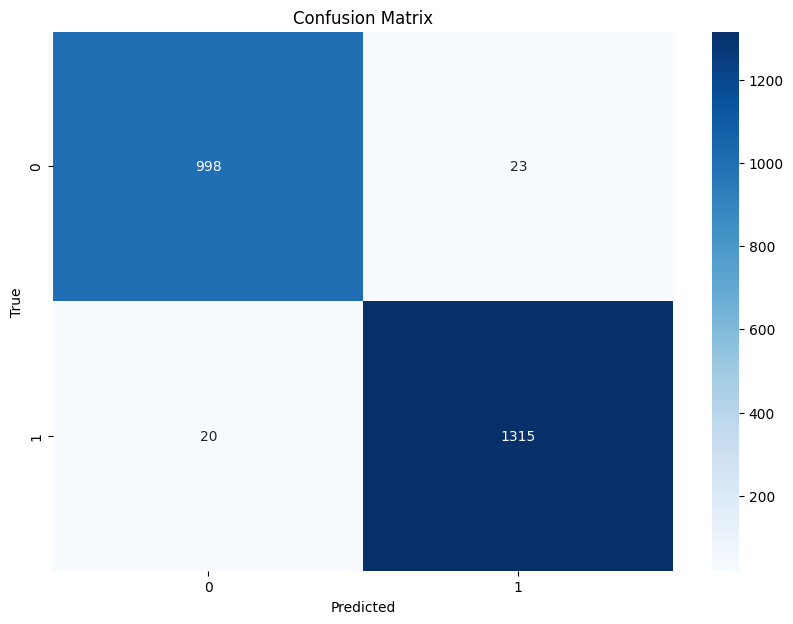

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
from keras.models import load_model
# Import seaborn for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Load the model
model = load_model('deepfake_audio_model.h5')

# Evaluate on the test set
y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train, axis=1)

# Convert class names to strings if necessary
target_names = [str(cls) for cls in label_encoder.classes_]

# Calculate and print evaluation metrics
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1021
           1       0.98      0.99      0.98      1335

    accuracy                           0.98      2356
   macro avg       0.98      0.98      0.98      2356
weighted avg       0.98      0.98      0.98      2356



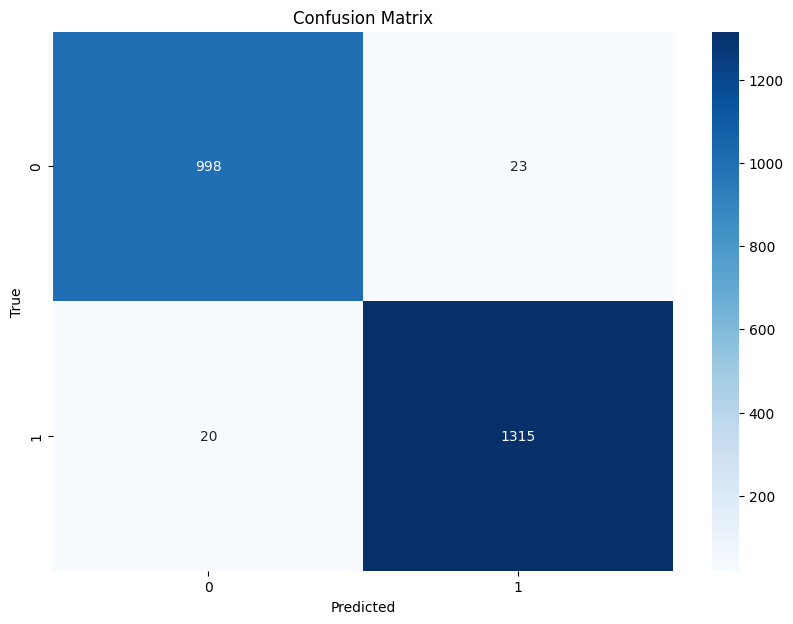

In [ ]:
# Import seaborn for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Correcting the target names by converting them to strings
target_names = label_encoder.classes_.astype(str)

# Calculate evaluation metrics
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Correction code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle  # For saving and loading scaler and label encoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Load the CSV file
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AVCeleb Dataset/Audio_dataset.csv')  # Adjusted to the uploaded path

# Display the first few rows of the dataset
print(data.head())

                                          Audio Path  Label
0  /content/drive/MyDrive/Colab Notebooks/AVCeleb...      0
1  /content/drive/MyDrive/Colab Notebooks/AVCeleb...      1
2  /content/drive/MyDrive/Colab Notebooks/AVCeleb...      1
3  /content/drive/MyDrive/Colab Notebooks/AVCeleb...      1
4  /content/drive/MyDrive/Colab Notebooks/AVCeleb...      1


In [ ]:
# Function to extract features from an audio file
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)

    # Extracting Spectral Features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

    # Extracting MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Combining all features into a single array
    features = np.hstack([spectral_centroid, spectral_bandwidth, spectral_rolloff, mfccs_mean])
    return features

In [ ]:
# Extract features and labels from the dataset
X = []
y = []

for index, row in data.iterrows():
    audio_path = row['Audio Path']
    label = row['Label']
    try:
        features = extract_features(audio_path)
        X.append(features)
        y.append(label)
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Save the label encoder
with open('/content/drive/MyDrive/Colab Notebooks/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler
with open('/content/drive/MyDrive/Colab Notebooks/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
# Define the model architecture
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Model training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ModelCheckpoint('deepfake_audio_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=callbacks)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 14, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,122 (113.76 KB)

 Trainable params: 29,122 (113.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6908 - loss: 0.5760
Epoch 1: val_loss improved from inf to 0.45041, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6915 - loss: 0.5752 - val_accuracy: 0.7847 - val_loss: 0.4504
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8089 - loss: 0.4287
Epoch 2: val_loss improved from 0.45041 to 0.41097, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8091 - loss: 0.4285 - val_accuracy: 0.8254 - val_loss: 0.4110
Epoch 3/100
52/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8280 - loss: 0.3966
Epoch 3: val_loss improved from 0.41097 to 0.38970, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8237 - loss: 0.3994 - val_accuracy: 0.8390 - val_loss: 0.3897
Epoch 4/100
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8447 - loss: 0.3762
Epoch 4: val_loss improved from 0.38970 to 0.36785, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8445 - loss: 0.3762 - val_accuracy: 0.8305 - val_loss: 0.3678
Epoch 5/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8454 - loss: 0.3710
Epoch 5: val_loss improved from 0.36785 to 0.35331, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8440 - loss: 0.3677 - val_accuracy: 0.8508 - val_loss: 0.3533
Epoch 6/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8467 - loss: 0.3590
Epoch 6: val_loss improved from 0.35331 to 0.33501, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8524 - loss: 0.3530 - val_accuracy: 0.8492 - val_loss: 0.3350
Epoch 7/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8384 - loss: 0.3649
Epoch 7: val_loss improved from 0.33501 to 0.32755, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8415 - loss: 0.3608 - val_accuracy: 0.8661 - val_loss: 0.3275
Epoch 8/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8595 - loss: 0.3430
Epoch 8: val_loss improved from 0.32755 to 0.32506, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8595 - loss: 0.3427 - val_accuracy: 0.8729 - val_loss: 0.3251
Epoch 9/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8900 - loss: 0.2994
Epoch 9: val_loss improved from 0.32506 to 0.29630, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8849 - loss: 0.3050 - val_accuracy: 0.8864 - val_loss: 0.2963
Epoch 10/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8738 - loss: 0.3041
Epoch 10: val_loss improved from 0.29630 to 0.29129, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8747 - loss: 0.3035 - val_accuracy: 0.8983 - val_loss: 0.2913
Epoch 11/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8684 - loss: 0.3023
Epoch 11: val_loss improved from 0.29129 to 0.29058, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8685 - loss: 0.3023 - val_accuracy: 0.9017 - val_loss: 0.2906
Epoch 12/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.2987
Epoch 12: val_loss improved from 0.29058 to 0.28415, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8745 - loss: 0.2971 - val_accuracy: 0.8831 - val_loss: 0.2841
Epoch 13/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8996 - loss: 0.2709
Epoch 13: val_loss improved from 0.28415 to 0.26630, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8995 - loss: 0.2718 - val_accuracy: 0.9119 - val_loss: 0.2663
Epoch 14/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8872 - loss: 0.2715
Epoch 14: val_loss improved from 0.26630 to 0.25470, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8889 - loss: 0.2727 - val_accuracy: 0.9017 - val_loss: 0.2547
Epoch 15/100
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9035 - loss: 0.2603
Epoch 15: val_loss did not improve from 0.25470
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9031 - loss: 0.2606 - val_accuracy: 0.9102 - val_loss: 0.2547
Epoch 16/100
52/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8929 - loss: 0.2882
Epoch 16: val_loss improved from 0.25470 to 0.24689, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8953 - loss: 0.2844 - val_accuracy: 0.9068 - val_loss: 0.2469
Epoch 17/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9047 - loss: 0.2480
Epoch 17: val_loss improved from 0.24689 to 0.24387, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9058 - loss: 0.2464 - val_accuracy: 0.9085 - val_loss: 0.2439
Epoch 18/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9146 - loss: 0.2357
Epoch 18: val_loss did not improve from 0.24387
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9132 - loss: 0.2388 - val_accuracy: 0.9119 - val_loss: 0.2495
Epoch 19/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9144 - loss: 0.2462
Epoch 19: val_loss did not improve from 0.24387
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9117 - loss: 0.2473 - val_accuracy: 0.9000 - val_loss: 0.2444
Epoch 20/100
52/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9094 - loss: 0.2359
Epoch 20: val_loss improved from 0.24387 to 0.22627, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9107 - loss: 0.2346 - val_accuracy: 0.9034 - val_loss: 0.2263
Epoch 21/100
52/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9209 - loss: 0.2116
Epoch 21: val_loss improved from 0.22627 to 0.21756, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9195 - loss: 0.2175 - val_accuracy: 0.9186 - val_loss: 0.2176
Epoch 22/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9226 - loss: 0.2186
Epoch 22: val_loss did not improve from 0.21756
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9224 - loss: 0.2188 - val_accuracy: 0.9237 - val_loss: 0.2187
Epoch 23/100
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9162 - loss: 0.2361
Epoch 23: val_loss improved from 0.21756 to 0.21689, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9162 - loss: 0.2355 - val_accuracy: 0.9220 - val_loss: 0.2169
Epoch 24/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9368 - loss: 0.1871
Epoch 24: val_loss improved from 0.21689 to 0.20982, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9335 - loss: 0.1968 - val_accuracy: 0.9237 - val_loss: 0.2098
Epoch 25/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9280 - loss: 0.2028
Epoch 25: val_loss improved from 0.20982 to 0.20433, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9280 - loss: 0.2028 - val_accuracy: 0.9186 - val_loss: 0.2043
Epoch 26/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9271 - loss: 0.1929
Epoch 26: val_loss did not improve from 0.20433
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9269 - loss: 0.1934 - val_accuracy: 0.9102 - val_loss: 0.2196
Epoch 27/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9221 - loss: 0.2350
Epoch 27: val_loss did not improve from 0.20433
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9238 - loss: 0.2273 - val_accuracy: 0.9220 - val_loss: 0.2133
Epoch 28/100
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9275 - loss: 0.1992
Epoch 28: val_loss improved from 0.20433 to 0.19499, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9276 - loss: 0.1995 - val_accuracy: 0.9237 - val_loss: 0.1950
Epoch 29/100
70/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9320 - loss: 0.2145
Epoch 29: val_loss improved from 0.19499 to 0.18889, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9321 - loss: 0.2132 - val_accuracy: 0.9220 - val_loss: 0.1889
Epoch 30/100
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9322 - loss: 0.1838
Epoch 30: val_loss improved from 0.18889 to 0.18743, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9327 - loss: 0.1834 - val_accuracy: 0.9288 - val_loss: 0.1874
Epoch 31/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9256 - loss: 0.1972
Epoch 31: val_loss did not improve from 0.18743
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9251 - loss: 0.1943 - val_accuracy: 0.9288 - val_loss: 0.2008
Epoch 32/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9236 - loss: 0.2019
Epoch 32: val_loss did not improve from 0.18743
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9237 - loss: 0.2017 - val_accuracy: 0.9254 - val_loss: 0.1892
Epoch 33/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9360 - loss: 0.1741
Epoch 33: val_loss did not improve from 0.18743
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9361 - loss: 0.1740 - val_accuracy: 0.9237 - val_loss: 0.1898
Epoch 34/100
52/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.1793
Epoch 34: val_loss improved from 0.18743 to 0.18031,

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9357 - loss: 0.1812 - val_accuracy: 0.9390 - val_loss: 0.1803
Epoch 35/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9343 - loss: 0.1608
Epoch 35: val_loss did not improve from 0.18031
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9343 - loss: 0.1612 - val_accuracy: 0.9322 - val_loss: 0.1958
Epoch 36/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9288 - loss: 0.1964
Epoch 36: val_loss improved from 0.18031 to 0.17957, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9291 - loss: 0.1959 - val_accuracy: 0.9271 - val_loss: 0.1796
Epoch 37/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9425 - loss: 0.1707
Epoch 37: val_loss did not improve from 0.17957
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9417 - loss: 0.1709 - val_accuracy: 0.9220 - val_loss: 0.1880
Epoch 38/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9407 - loss: 0.1862
Epoch 38: val_loss did not improve from 0.17957
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9407 - loss: 0.1822 - val_accuracy: 0.9271 - val_loss: 0.1819
Epoch 39/100
53/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9405 - loss: 0.1586
Epoch 39: val_loss did not improve from 0.17957
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9394 - loss: 0.1627 - val_accuracy: 0.9322 - val_loss: 0.1819
Epoch 40/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9415 - loss: 0.1488
Epoch 40: val_loss did not improve from 0.17957
74/7

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9413 - loss: 0.1697 - val_accuracy: 0.9356 - val_loss: 0.1742
Epoch 46/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9296 - loss: 0.1774
Epoch 46: val_loss did not improve from 0.17420
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9319 - loss: 0.1736 - val_accuracy: 0.9407 - val_loss: 0.1766
Epoch 47/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9467 - loss: 0.1525
Epoch 47: val_loss did not improve from 0.17420
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9467 - loss: 0.1525 - val_accuracy: 0.9339 - val_loss: 0.1775
Epoch 48/100
52/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9456 - loss: 0.1470
Epoch 48: val_loss improved from 0.17420 to 0.17071, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9469 - loss: 0.1454 - val_accuracy: 0.9390 - val_loss: 0.1707
Epoch 49/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9604 - loss: 0.1213
Epoch 49: val_loss did not improve from 0.17071
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9573 - loss: 0.1263 - val_accuracy: 0.9373 - val_loss: 0.1740
Epoch 50/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9594 - loss: 0.1336
Epoch 50: val_loss did not improve from 0.17071
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9593 - loss: 0.1337 - val_accuracy: 0.9356 - val_loss: 0.1743
Epoch 51/100
70/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9571 - loss: 0.1248
Epoch 51: val_loss did not improve from 0.17071
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9567 - loss: 0.1259 - val_accuracy: 0.9356 - val_loss: 0.1757
Epoch 52/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9599 - loss: 0.1231
Epoch 52: val_loss did not improve from 0.17071
74/7

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9571 - loss: 0.1182 - val_accuracy: 0.9390 - val_loss: 0.1700
Epoch 56/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9521 - loss: 0.1237
Epoch 56: val_loss improved from 0.17004 to 0.16495, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9519 - loss: 0.1278 - val_accuracy: 0.9356 - val_loss: 0.1650
Epoch 57/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9540 - loss: 0.1384
Epoch 57: val_loss did not improve from 0.16495
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9526 - loss: 0.1422 - val_accuracy: 0.9424 - val_loss: 0.1722
Epoch 58/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9567 - loss: 0.1369
Epoch 58: val_loss did not improve from 0.16495
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9559 - loss: 0.1370 - val_accuracy: 0.9373 - val_loss: 0.1778
Epoch 59/100
52/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9495 - loss: 0.1218
Epoch 59: val_loss did not improve from 0.16495
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9501 - loss: 0.1247 - val_accuracy: 0.9407 - val_loss: 0.1703
Epoch 60/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9523 - loss: 0.1256
Epoch 60: val_loss did not improve from 0.16495
74/7

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9597 - loss: 0.1174 - val_accuracy: 0.9458 - val_loss: 0.1626
Epoch 62/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9526 - loss: 0.1166
Epoch 62: val_loss did not improve from 0.16261
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9531 - loss: 0.1203 - val_accuracy: 0.9441 - val_loss: 0.1660
Epoch 63/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9603 - loss: 0.1214
Epoch 63: val_loss improved from 0.16261 to 0.15343, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9601 - loss: 0.1190 - val_accuracy: 0.9492 - val_loss: 0.1534
Epoch 64/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9596 - loss: 0.1246
Epoch 64: val_loss did not improve from 0.15343
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9580 - loss: 0.1243 - val_accuracy: 0.9441 - val_loss: 0.1560
Epoch 65/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9604 - loss: 0.1129
Epoch 65: val_loss did not improve from 0.15343
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9592 - loss: 0.1157 - val_accuracy: 0.9373 - val_loss: 0.1610
Epoch 66/100
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9632 - loss: 0.1258
Epoch 66: val_loss did not improve from 0.15343
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9631 - loss: 0.1255 - val_accuracy: 0.9458 - val_loss: 0.1597
Epoch 67/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9620 - loss: 0.1157
Epoch 67: val_loss did not improve from 0.15343
74/7

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9629 - loss: 0.1108 - val_accuracy: 0.9424 - val_loss: 0.1531
Epoch 73/100
70/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9670 - loss: 0.1037
Epoch 73: val_loss improved from 0.15306 to 0.14274, saving model to deepfake_audio_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9666 - loss: 0.1043 - val_accuracy: 0.9559 - val_loss: 0.1427
Epoch 74/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9601 - loss: 0.1069
Epoch 74: val_loss did not improve from 0.14274
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9612 - loss: 0.1058 - val_accuracy: 0.9559 - val_loss: 0.1439
Epoch 75/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9634 - loss: 0.1065
Epoch 75: val_loss did not improve from 0.14274
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9634 - loss: 0.1065 - val_accuracy: 0.9525 - val_loss: 0.1534
Epoch 76/100
50/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9719 - loss: 0.0928
Epoch 76: val_loss did not improve from 0.14274
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9709 - loss: 0.0934 - val_accuracy: 0.9559 - val_loss: 0.1467
Epoch 77/100
51/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9724 - loss: 0.0880
Epoch 77: val_loss did not improve from 0.14274
74/7

In [ ]:
# Save the entire model for future use
model.save('/content/drive/MyDrive/Colab Notebooks/deepfake_audio_detection_model.h5')


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1021
           1       0.99      0.99      0.99      1335

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



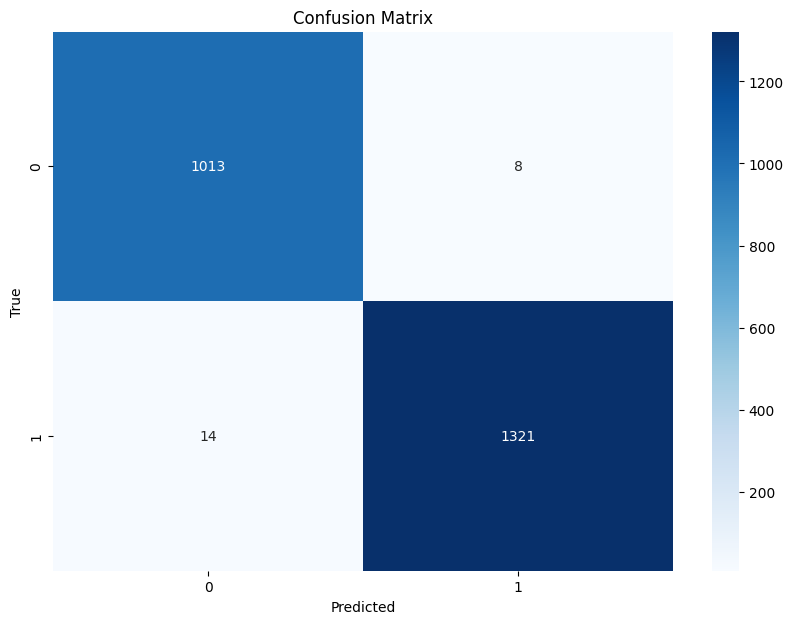

In [ ]:
# Evaluate on the training set
y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train, axis=1)

# Convert class names to strings if necessary
target_names = [str(cls) for cls in label_encoder.classes_]

# Calculate and print evaluation metrics
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Prediction code

In [ ]:
# Function to predict and label external audio files
def predict_external_audio(model_path, scaler_path, label_encoder_path, audio_path):
    # Load the trained model
    model = load_model(model_path)

    # Load the scaler and label encoder
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    with open(label_encoder_path, 'rb') as f:
        label_encoder = pickle.load(f)

    # Extract features from the external audio file
    features = extract_features(audio_path)

    # Scale the features
    features_scaled = scaler.transform([features])

    # Add a dimension for the Conv1D model
    features_scaled = np.expand_dims(features_scaled, axis=2)

    # Predict the class
    prediction = model.predict(features_scaled)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Retrieve the label from the encoder
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    return predicted_label

# Example usage of predict_external_audio
external_audio_path = '/content/drive/MyDrive/Colab Notebooks/ElevenLabs_2025-02-22T18_06_27_Rachel_pre_s50_sb75_se0_b_m2.mp3'
predicted_label = predict_external_audio(
    '/content/drive/MyDrive/Colab Notebooks/deepfake_audio_detection_model.h5',
    '/content/drive/MyDrive/Colab Notebooks/scaler.pkl',
    '/content/drive/MyDrive/Colab Notebooks/label_encoder.pkl',
    external_audio_path
)
print(f'The predicted label for the external audio is: {predicted_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
The predicted label for the external audio is: 0
